In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow import keras
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import pathlib
from os import getcwd
from google.colab import drive
%matplotlib inline

In [6]:
print(tf.__version__)
print(tfds.__version__)

2.12.0
4.9.2


In [7]:
drive.mount('/content/drive')
DATASET_DIR = '/content/drive/MyDrive/DATASETS'
BATCH_SIZE = 32
IMG_HEIGHT = 300
IMG_WIDTH = 300
SHUFFLE_VALUE = True
AUTOTUNE = tf.data.AUTOTUNE

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### DATASET PREPROCESSING

In [8]:
# Make Train Dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=345,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE
)

# Make Val Dataset
val_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=345,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE
)

# Make Test Dataset
val_batches = tf.data.experimental.cardinality(dataset=val_ds)
test_ds = val_ds.take((1 * val_batches) // 2)
val_ds = val_ds.skip((1 * val_batches) // 2)

print('\nSPLITTING VALIDATION FOR TESTING:')
print(f'Using {tf.data.experimental.cardinality(dataset=val_ds) * BATCH_SIZE} files for validation')
print(f'Using {tf.data.experimental.cardinality(dataset=test_ds) * BATCH_SIZE} files for testing')


Found 8887 files belonging to 13 classes.
Using 7110 files for training.
Found 8887 files belonging to 13 classes.
Using 1777 files for validation.

SPLITTING VALIDATION FOR TESTING:
Using 896 files for validation
Using 896 files for testing


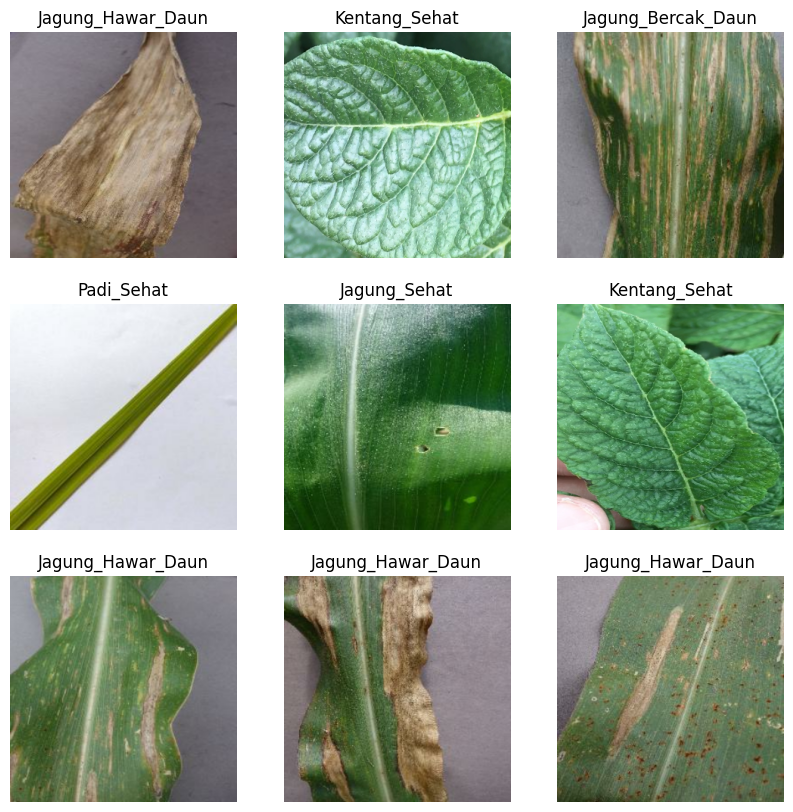

In [9]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'), 
  tf.keras.layers.RandomRotation(factor=0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomBrightness(factor=[-0.3,0.3]),
  tf.keras.layers.RandomContrast(factor=0.2)
])

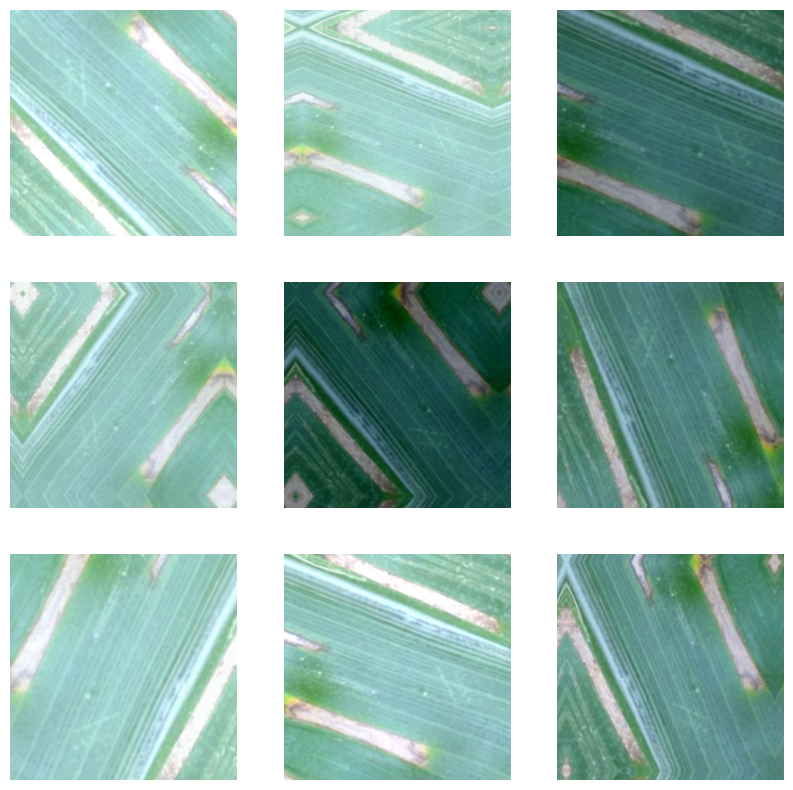

In [11]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### MODEL

In [13]:
base_model = tf.keras.applications.EfficientNetB3(input_shape=(300,300,3), include_top=False, weights='imagenet')
base_model.trainable = True

43941136/43941136 [==============================] - 3s 0us/step


In [14]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  385


In [15]:
# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(300,300,3)),
    data_augmentation,
    base_model,
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(13, activation='softmax')
])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 32)          442400    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                  

In [18]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [19]:
#Evaluate Our Final Model Architectures
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)


In [20]:
history_ft = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds, callbacks=[callback])

Epoch 1/30
223/223 [==============================] - 1520s 7s/step - loss: 1.0132 - accuracy: 0.6447 - val_loss: 0.4040 - val_accuracy: 0.8524
Epoch 2/30
223/223 [==============================] - 114s 509ms/step - loss: 0.4187 - accuracy: 0.8466 - val_loss: 0.3043 - val_accuracy: 0.8820
Epoch 3/30
223/223 [==============================] - 114s 508ms/step - loss: 0.3112 - accuracy: 0.8900 - val_loss: 0.2909 - val_accuracy: 0.8944
Epoch 4/30
223/223 [==============================] - 114s 506ms/step - loss: 0.2728 - accuracy: 0.9020 - val_loss: 0.2868 - val_accuracy: 0.8944
Epoch 5/30
223/223 [==============================] - 114s 508ms/step - loss: 0.2317 - accuracy: 0.9107 - val_loss: 0.2625 - val_accuracy: 0.9171
Epoch 6/30
223/223 [==============================] - 115s 510ms/step - loss: 0.2090 - accuracy: 0.9231 - val_loss: 0.2536 - val_accuracy: 0.9171
Epoch 7/30
223/223 [==============================] - 114s 509ms/step - loss: 0.2017 - accuracy: 0.9262 - val_loss: 0.2292 - v

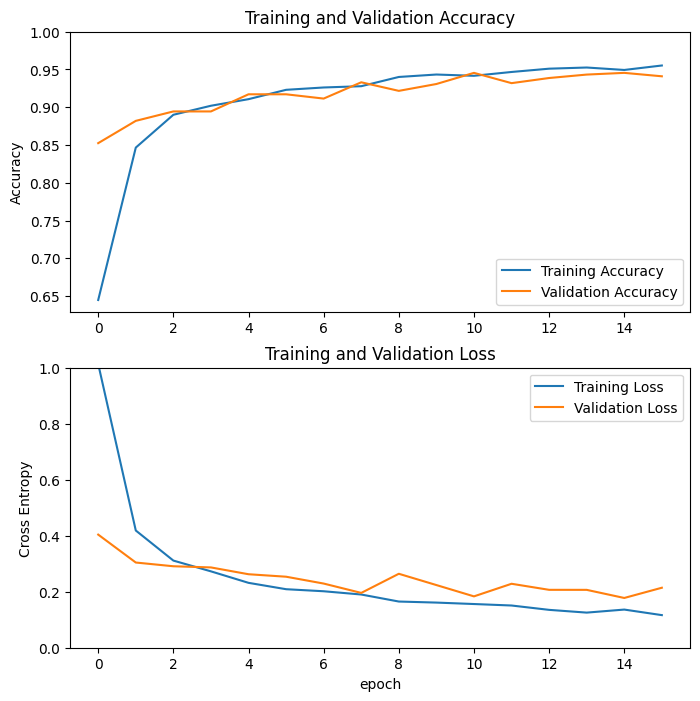

In [21]:
acc = history_ft.history['accuracy']
val_acc = history_ft.history['val_accuracy']

loss = history_ft.history['loss']
val_loss = history_ft.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

28/28 [==============================] - 7s 206ms/step - loss: 0.1733 - accuracy: 0.9509
Test accuracy : 0.9508928656578064


In [23]:
test_data = list(test_ds)
features = np.concatenate([test_data[n][0] for n in range(0, len(test_data))])
targets = np.concatenate([test_data[n][1] for n in range(0, len(test_data))])

In [24]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [25]:
predictions = probability_model.predict(features)

28/28 [==============================] - 9s 190ms/step


Predictions:
 [[0.06795596 0.18465896 0.0679441  ... 0.0679441  0.0679441  0.0679441 ]
 [0.06794272 0.06794272 0.06794272 ... 0.06794272 0.06794272 0.06794272]
 [0.06794939 0.06794363 0.18467267 ... 0.06794344 0.06794344 0.06794344]
 ...
 [0.06794724 0.18467769 0.06794319 ... 0.06794319 0.06794319 0.06794319]
 [0.18462323 0.06797256 0.06794585 ... 0.06794584 0.06794584 0.06794584]
 [0.06794276 0.06794273 0.06794276 ... 0.06794273 0.06794273 0.06794275]]
Labels:
 [ 1  3  2  6  2 10  9  1  7  1  6 10  2  2  6 10  3  9  3  0  3  1  2  0
  4  5  5  2  3  2  9 12  6  1 11 11  8  9 10  0  4 12  3  2  3  8  3  9
  2  0  3  3  3  8  5  2  2  9  9 10  8 12  9  2 11  2 10  5 11  4  1  1
  1  4  3 12  1  6  5  1 11  8  2  3 11  0  8  1 12  4  6  3  8  3  3  7
  2  3  4  0  6  0 12  2  5  9  1  0  1  8  2  9  2  9  7  0  1  0  4  1
  3  4  0  0  1  2  2  7  2  2  2  2  1  0  1  2  6 10  0  8  1  1  2 10
  6  1 11  9  2  0  8  3  0  3  2  7  0 10  7  5  3 10 12  6  8  1  8  3
  6  8  4  1  3  2 12 

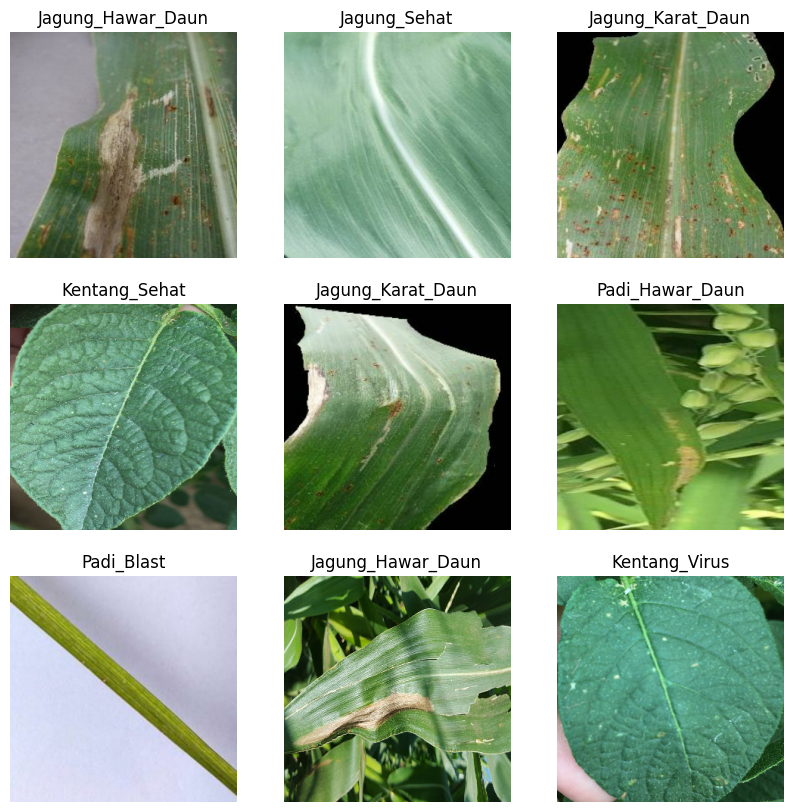

In [26]:
print('Predictions:\n', predictions)
print('Labels:\n', targets)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(features[i].astype("uint8"))
 
  plt.title(class_names[np.argmax(predictions[i])])
  plt.axis("off")